In [ ]:
import os

os.chdir('/home/jupyter-choi/')
print(os.getcwd())

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import RidgeCV
import autosklearn.regression

def flatten_data(data):
    return data.reshape(data.shape[0], -1)

def calculate_performance_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

def plot_original_vs_predicted(original, predicted, num_samples=5, sampling_rate=250):
    plt.figure(figsize=(20, 10))
    for i in range(min(num_samples, len(original))):
        cleaned_original = nk.ecg_clean(original[i], sampling_rate=sampling_rate, method='neurokit')
        cleaned_predicted = nk.ecg_clean(predicted[i], sampling_rate=sampling_rate, method='neurokit')

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.plot(cleaned_original, label="Original")
        plt.title(f"Original 2nd Feature Sample {i+1}")
        plt.legend()

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.plot(cleaned_predicted, label="Predicted")
        plt.title(f"Predicted 3rd Feature Sample {i+1}")
        plt.legend()

    plt.tight_layout()
    plt.show()

def load_npy_data(folder_path):
    X_list, y_list = [], []
    processed_files = set()

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy') and file_name not in processed_files:
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)
            processed_files.add(file_name)

            if data.shape == (13, 5000):
                data = data[:12, :]
                X_list.append(data[0, :])  # 0번 특성을 입력으로 사용
                y_list.append(data[1, :])  # 1번 특성을 출력으로 사용

    return np.array(X_list), np.array(y_list)


folder_path = "hw/data_No20000_ALL/data"
X, y = load_npy_data(folder_path)


In [3]:
print(X.shape)

(40000, 5000)


In [4]:
print(y.shape)

(40000, 5000)


In [5]:
# def find_pqrst_and_calculate_hr(signal, sr):
#     try:
#         signals = signal.reshape(-1,)
#         signals = nk.ecg_clean(signals, sr, method='neurokit')
#         _, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
#         _, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

#         r_peaks = np.array(rpeaks['ECG_R_Peaks'])
#         r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

#         # p_peaks, q_peaks, s_peaks, t_peaks 정의
#         p_peaks = np.array(waves_peak['ECG_P_Peaks'])
#         q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
#         s_peaks = np.array(waves_peak['ECG_S_Peaks'])
#         t_peaks = np.array(waves_peak['ECG_T_Peaks'])

#         # NaN 값 필터링
#         p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')
#         q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')
#         s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')
#         t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

#         if len(r_peaks) < 2:
#             return [], [], [], [], [], np.nan

#         # RR 간격 계산
#         rr_intervals = calculate_rr_intervals(r_peaks, sr)
#         if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:
#             return [], [], [], [], [], np.nan

#         hr = 60 / np.mean(rr_intervals)
#         return p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr

#     except Exception as e:
#         print(f"Error: {e}")
#         return [], [], [], [], [], np.nan

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.utils import shuffle
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# ECG 데이터를 로드하는 함수 정의
def load_npy_data(folder_path):
    X_list, y_list = [], []
    processed_files = set()

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy') and file_name not in processed_files:
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)
            processed_files.add(file_name)

            if data.shape == (13, 5000):
                data = data[:12, :]
                signal = data[0, :]
                sr = 500
                
                # Check for NaN values in the signal
                if np.isnan(signal).any():
                    continue

                # ECG 신호 전처리
                signal = signal.reshape(-1,)
                signal = nk.ecg_clean(signal, sr, method='neurokit')
                _, rpeaks = nk.ecg_peaks(signal, sampling_rate=sr)
                
                try:
                    _, waves_peak = nk.ecg_delineate(signal, rpeaks, sampling_rate=sr, method='peak')
                except ValueError as e:
                    print(f"Skipping data due to error: {e}")
                    continue

                r_peaks = np.array(rpeaks['ECG_R_Peaks'])
                r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

                # p_peaks, q_peaks, s_peaks, t_peaks 정의
                p_peaks = np.array(waves_peak['ECG_P_Peaks'])
                q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
                s_peaks = np.array(waves_peak['ECG_S_Peaks'])
                t_peaks = np.array(waves_peak['ECG_T_Peaks'])

                # NaN 값 필터링
                p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')
                q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')
                s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')
                t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

                if len(r_peaks) < 2:
                    continue  # 이 경우 데이터를 스킵하고 다음 데이터로 이동

                # RR 간격 계산
                rr_intervals = calculate_rr_intervals(r_peaks, sr)
                if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:
                    continue  # 이 경우 데이터를 스킵하고 다음 데이터로 이동

                hr = 60 / np.mean(rr_intervals)

                # 0번과 1번 특성을 사용
                X_list.append(np.stack((signal, data[0, :]), axis=0))
                y_list.append(data[1, :])  # 1번 특성을 출력으로 사용

    return np.array(X_list), np.array(y_list)


def plot_original_vs_predicted(original, predicted, num_samples=5, sampling_rate=250):
    plt.figure(figsize=(20, 10))
    for i in range(min(num_samples, len(original))):
        cleaned_original = nk.ecg_clean(original[i], sampling_rate=sampling_rate, method='neurokit')
        cleaned_predicted = nk.ecg_clean(predicted[i], sampling_rate=sampling_rate, method='neurokit')

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.plot(cleaned_original, label="Original")
        plt.title(f"Original 2nd Feature Sample {i+1}")
        plt.legend()

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.plot(cleaned_predicted, label="Predicted")
        plt.title(f"Predicted 3rd Feature Sample {i+1}")
        plt.legend()

    plt.tight_layout()
    plt.show()


def calculate_rr_intervals(r_peaks, sr):
    rr_intervals = np.diff(r_peaks) / sr  # R 피크 간의 시간 간격을 초 단위로 계산
    return rr_intervals

def find_pqrst_and_calculate_hr(signal, sr):
    try:
        signals = signal.reshape(-1,)
        signals = nk.ecg_clean(signals, sr, method='neurokit')
        _, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
        _, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

        r_peaks = np.array(rpeaks['ECG_R_Peaks'])
        r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

        # p_peaks, q_peaks, s_peaks, t_peaks 정의
        p_peaks = np.array(waves_peak['ECG_P_Peaks'])
        q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
        s_peaks = np.array(waves_peak['ECG_S_Peaks'])
        t_peaks = np.array(waves_peak['ECG_T_Peaks'])

        # NaN 값 필터링
        p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')
        q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')
        s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')
        t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

        if len(r_peaks) < 2:
            return [], [], [], [], [], np.nan

        # RR 간격 계산
        rr_intervals = calculate_rr_intervals(r_peaks, sr)
        if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:
            return [], [], [], [], [], np.nan

        hr = 60 / np.mean(rr_intervals)
        return p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr

    except Exception as e:
        print(f"Error: {e}")
        return [], [], [], [], [], np.nan

# 데이터 폴더 경로
folder_path = "hw/data_No20000_ALL/data"

# ECG 데이터 로드
X, y = load_npy_data(folder_path)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Flatten the target data
y_train_flat, y_val_flat, y_test_flat = y_train[:, 0], y_val[:, 0], y_test[:, 0]

# Define alpha values for RidgeCV
alpha_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 10000000, 10000000000, 10000000000, 1000000000000, 100000000000000]

# Train the RidgeCV model
ridge_cv_model = RidgeCV(alphas=alpha_values)
ridge_cv_model.fit(X_train, y_train_single_output)  # y_train_single_output 사용

# Make predictions on training, validation, and test sets
ridge_cv_predictions = {
    "train": ridge_cv_model.predict(X_train),
    "val": ridge_cv_model.predict(X_val),
    "test": ridge_cv_model.predict(X_test)
}

# Calculate and print performance metrics
for key, value in ridge_cv_predictions.items():
    mse = mean_squared_error(y_test_flat if key == "test" else y_train_flat if key == "train" else y_val_flat, value)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_flat if key == "test" else y_train_flat if key == "train" else y_val_flat, value)
    print(f"RidgeCV - {key.capitalize()} Set - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")


# y_train_flat에서 첫 번째 열만 사용하여 y_train_single_output 생성
y_train_single_output = y_train_flat[:, 0]

# Shuffle the data for visualization
X_train_reduced, y_train_single_output_reduced = shuffle(X_train, y_train_flat, n_samples=100, random_state=42)

# RidgeCV 모델의 예측 결과를 사용하여 시각화
plot_original_vs_predicted(X_test, ridge_cv_model.predict(X_test), num_samples=5)



KeyboardInterrupt: 

In [ ]:
# RR간격이 짧으면 스킵함

import numpy as np
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.utils import shuffle
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def load_npy_data(folder_path):
    X_list, y_list = [], []
    processed_files = set()
    skipped_files = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy') and file_name not in processed_files:
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)
            processed_files.add(file_name)

            if data.shape == (13, 5000):
                data = data[:12, :]
                signal = data[0, :]
                sr = 500
                
                # Check for NaN values in the signal
                if np.isnan(signal).any():
                    continue

                # ECG 신호 전처리
                signal = signal.reshape(-1,)
                signal = nk.ecg_clean(signal, sr, method='neurokit')
                
                try:
                    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=sr)

                    # R 피크가 충분한지 확인
                    if len(rpeaks['ECG_R_Peaks']) < 2:
                        print(f"Skipping file '{file_name}' due to insufficient R peaks.")
                        continue

                    # PQRS 파형과 심박수 추출
                    p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr = find_pqrst_and_calculate_hr(signal, sr)

                    # 추출된 특성을 데이터셋에 추가
                    features = np.concatenate([signal, p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, [hr]])
                    X_list.append(features)
                    y_list.append(data[1, :])  # 1번 특성을 출력으로 사용

                except Exception as e:
                    print(f"Error processing file '{file_name}': {e}")
                    continue  # 오류가 발생한 파일을 스킵하고 다음 파일로 이동

    print(f"Skipped {len(skipped_files)} files due to errors: {skipped_files}")
    return np.array(X_list), np.array(y_list)

def plot_original_vs_predicted(original, predicted, num_samples=5, sampling_rate=250):
    plt.figure(figsize=(20, 10))
    for i in range(min(num_samples, len(original))):
        cleaned_original = nk.ecg_clean(original[i], sampling_rate=sampling_rate, method='neurokit')
        cleaned_predicted = nk.ecg_clean(predicted[i], sampling_rate=sampling_rate, method='neurokit')

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.plot(cleaned_original, label="Original")
        plt.title(f"Original 2nd Feature Sample {i+1}")
        plt.legend()

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.plot(cleaned_predicted, label="Predicted")
        plt.title(f"Predicted 3rd Feature Sample {i+1}")
        plt.legend()

    plt.tight_layout()
    plt.show()


def calculate_rr_intervals(r_peaks, sr):
    rr_intervals = np.diff(r_peaks) / sr  # R 피크 간의 시간 간격을 초 단위로 계산
    return rr_intervals

def find_pqrst_and_calculate_hr(signal, sr):
    try:
        signals = signal.reshape(-1,)
        signals = nk.ecg_clean(signals, sr, method='neurokit')
        _, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
        _, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

        r_peaks = np.array(rpeaks['ECG_R_Peaks'])
        r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

        # p_peaks, q_peaks, s_peaks, t_peaks 정의
        p_peaks = np.array(waves_peak['ECG_P_Peaks'])
        q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
        s_peaks = np.array(waves_peak['ECG_S_Peaks'])
        t_peaks = np.array(waves_peak['ECG_T_Peaks'])

        # NaN 값 필터링
        p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')
        q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')
        s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')
        t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

        if len(r_peaks) < 2:
            return [], [], [], [], [], np.nan

        # RR 간격 계산
        rr_intervals = calculate_rr_intervals(r_peaks, sr)
        if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:
            return [], [], [], [], [], np.nan

        hr = 60 / np.mean(rr_intervals)
        return p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr

    except Exception as e:
        print(f"Error: {e}")
        return [], [], [], [], [], np.nan

# 데이터 폴더 경로
folder_path = "hw/data_No20000_ALL/data"

# ECG 데이터 로드
X, y = load_npy_data(folder_path)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Flatten the target data
y_train_flat, y_val_flat, y_test_flat = y_train[:, 0], y_val[:, 0], y_test[:, 0]

# Define alpha values for RidgeCV
alpha_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 10000000, 10000000000, 10000000000, 1000000000000, 100000000000000]

# y_train_flat에서 첫 번째 열을 사용할 필요가 없으므로, y_train_flat 자체를 사용
y_train_single_output = y_train_flat

# Train the RidgeCV model
ridge_cv_model = RidgeCV(alphas=alpha_values)
ridge_cv_model.fit(X_train, y_train_single_output)  # Now y_train_single_output is defined

# Make predictions on training, validation, and test sets
ridge_cv_predictions = {
    "train": ridge_cv_model.predict(X_train),
    "val": ridge_cv_model.predict(X_val),
    "test": ridge_cv_model.predict(X_test)
}

# Calculate and print performance metrics
for key, value in ridge_cv_predictions.items():
    mse = mean_squared_error(y_test_flat if key == "test" else y_train_flat if key == "train" else y_val_flat, value)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_flat if key == "test" else y_train_flat if key == "train" else y_val_flat, value)
    print(f"RidgeCV - {key.capitalize()} Set - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")



# y_train_flat에서 첫 번째 열만 사용하여 y_train_single_output 생성
y_train_single_output = y_train_flat[:, 0]

# Shuffle the data for visualization
X_train_reduced, y_train_single_output_reduced = shuffle(X_train, y_train_flat, n_samples=100, random_state=42)

# RidgeCV 모델의 예측 결과를 사용하여 시각화
plot_original_vs_predicted(X_test, ridge_cv_model.predict(X_test), num_samples=5)



/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: integer division or modulo by zero


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: integer division or modulo by zero
Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Skipping file 'wave106393.npy' due to insufficient R peaks.


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: '[5008] not in index'
Error: '[5011] not in index'
Error: '[5008] not in index'
Error: '[5007] not in index'


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Skipping file 'wave106396.npy' due to insufficient R peaks.


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: integer division or modulo by zero


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: integer division or modulo by zero
Skipping file 'wave118589.npy' due to insufficient R peaks.


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: integer division or modulo by zero


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Skipping file 'wave106391.npy' due to insufficient R peaks.


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer


In [1]:
print(x_list)

NameError: name 'x_list' is not defined

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import neurokit2 as nk

# ECG 데이터를 로드하는 함수 정의
def load_npy_data(folder_path):
    X_list, y_list = [], []
    processed_files = set()

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy') and file_name not in processed_files:
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)
            processed_files.add(file_name)

            if data.shape == (13, 5000):
                data = data[:12, :]
                X_list.append(data[0, :])  # 0번 특성을 입력으로 사용
                y_list.append(data[1, :])  # 1번 특성을 출력으로 사용

    return np.array(X_list), np.array(y_list)

def calculate_rr_intervals(r_peaks, sr):
    rr_intervals = np.diff(r_peaks) / sr  # R 피크 간의 시간 간격을 초 단위로 계산
    return rr_intervals

def find_pqrst_and_calculate_hr(signal, sr):
    try:
        signals = signal.reshape(-1,)
        signals = nk.ecg_clean(signals, sr, method='neurokit')
        _, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
        _, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

        r_peaks = np.array(rpeaks['ECG_R_Peaks'])
        r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

        # p_peaks, q_peaks, s_peaks, t_peaks 정의
        p_peaks = np.array(waves_peak['ECG_P_Peaks'])
        q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
        s_peaks = np.array(waves_peak['ECG_S_Peaks'])
        t_peaks = np.array(waves_peak['ECG_T_Peaks'])

        # NaN 값 필터링
        p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')
        q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')
        s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')
        t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

        if len(r_peaks) < 2:
            return [], [], [], [], [], np.nan

        # RR 간격 계산
        rr_intervals = calculate_rr_intervals(r_peaks, sr)
        if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:
            return [], [], [], [], [], np.nan

        hr = 60 / np.mean(rr_intervals)
        return p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr

    except Exception as e:
        print(f"Error: {e}")
        return [], [], [], [], [], np.nan



# 데이터 폴더 경로
folder_path = "hw/data_No20000_ALL/data"

# ECG 데이터 로드
X, y = load_npy_data(folder_path)

# ECG 신호 선택 (예: 첫 번째 신호)
signal = X[0]  # 이 부분을 선택하거나 원하는 ECG 신호로 변경

# 샘플링 속도 설정
sr = 250  # 예: 250 샘플링 속도

# ECG 신호 분석
signals = signal.reshape(-1,)
signals = nk.ecg_clean(signals, sr, method='neurokit')
_, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
_, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

# find_pqrst_and_calculate_hr 함수 호출
p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr = find_pqrst_and_calculate_hr(signal, sr)

# 결과 출력
print("P 피크:", p_peaks)
print("Q 피크:", q_peaks)
print("R 피크:", r_peaks)
print("S 피크:", s_peaks)
print("T 피크:", t_peaks)
print("심박수 (HR):", hr)

P 피크: [1730 2160 3070 3511 3795 3962]
Q 피크: [1736 2166 3079 3517 3825 3977 4410]
R 피크: [ 265  446  708  889 1155 1337 1603 1779 2047 2224 2496 2949 3130 3395
 3570 3846 4027 4303 4484 4758 4940]
S 피크: [ 518  931 1371 1624 1833 2268 3206 3635 4082 4525]
T 피크: [ 548  999 1440 1666 1886 2330 3234 3671 4128 4585]
심박수 (HR): 64.17112299465239


In [ ]:
# ECG 신호 선택 (예: 첫 번째 신호)
signal = X[1]  # 이 부분을 선택하거나 원하는 ECG 신호로 변경

# 샘플링 속도 설정
sr = 500 

# ECG 신호 분석
signals = signal.reshape(-1,)
signals = nk.ecg_clean(signals, sr, method='neurokit')
_, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)
_, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate=sr, method='peak')

# find_pqrst_and_calculate_hr 함수 호출
p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, hr = find_pqrst_and_calculate_hr(signal, sr)

# RR 간격 계산
rr_intervals = calculate_rr_intervals(r_peaks, sr)

# 결과 출력
print("P 피크:", p_peaks)
print("Q 피크:", q_peaks)
print("R 피크:", r_peaks)
print("S 피크:", s_peaks)
print("T 피크:", t_peaks)
print("심박수 (HR):", hr)
print("RR 간격:", rr_intervals)


/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jupyter-choi/.conda/envs/hyeon/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


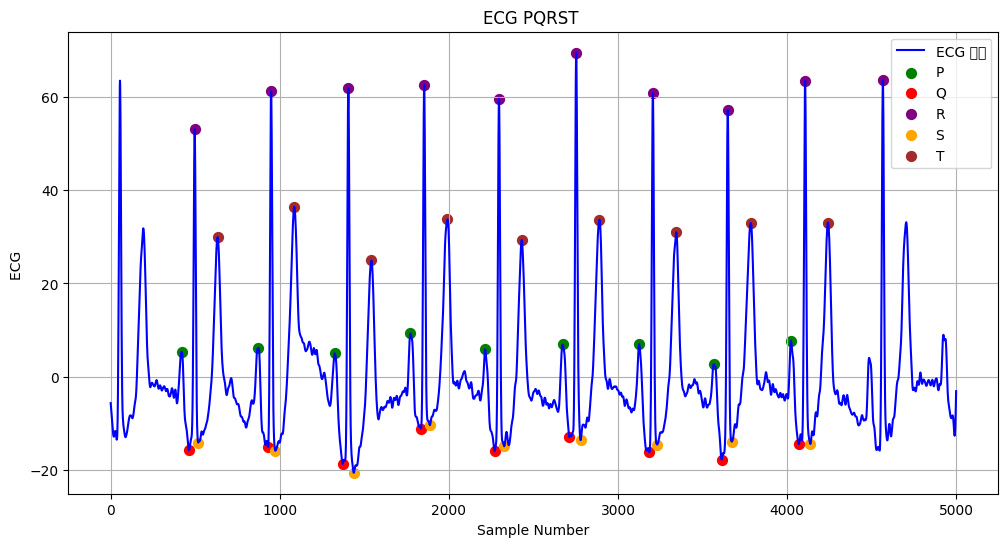

In [8]:
# ECG 신호와 피크 시각화
plt.figure(figsize=(12, 6))
plt.plot(signals, label='ECG 신호', color='blue')
plt.scatter(p_peaks, signals[p_peaks], label='P ', color='green', marker='o', s=50)
plt.scatter(q_peaks, signals[q_peaks], label='Q ', color='red', marker='o', s=50)
plt.scatter(r_peaks, signals[r_peaks], label='R ', color='purple', marker='o', s=50)
plt.scatter(s_peaks, signals[s_peaks], label='S ', color='orange', marker='o', s=50)
plt.scatter(t_peaks, signals[t_peaks], label='T ', color='brown', marker='o', s=50)
plt.xlabel('Sample Number')
plt.ylabel('ECG ')
plt.title('ECG PQRST ')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
y_train_flat, y_val_flat, y_test_flat = flatten_data(y_train), flatten_data(y_val), flatten_data(y_test)

alpha_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 10000000, 10000000000, 10000000000, 1000000000000, 100000000000000]
ridge_cv_model = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_cv_model.fit(X_train, y_train_flat)
best_alpha = ridge_cv_model.alpha_
print(f"Best alpha value: {best_alpha}")

ridge_cv_predictions = { "train": ridge_cv_model.predict(X_train), "val": ridge_cv_model.predict(X_val), "test": ridge_cv_model.predict(X_test) }
for key, value in ridge_cv_predictions.items():
    mse, rmse, r2 = calculate_performance_metrics(flatten_data(y_test if key == "test" else y_train if key == "train" else y_val), value)
    print(f"RidgeCV - {key.capitalize()} Set - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

from sklearn.utils import shuffle

# y_train_flat에서 첫 번째 열만 사용하여 y_train_single_output 생성
y_train_single_output = y_train_flat[:, 0]

# 데이터 세트 크기를 줄임
X_train_reduced, y_train_single_output_reduced = shuffle(X_train, y_train_single_output, n_samples=100, random_state=42)

# RidgeCV 모델의 예측 결과를 사용하여 시각화
plot_original_vs_predicted(X_test, ridge_cv_predictions["test"], num_samples=5)

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle

# ECG 데이터를 로드하는 함수 정의
def load_npy_data(folder_path):
    X_list, y_list = [], []
    processed_files = set()

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy') and file_name not in processed_files:
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)
            processed_files.add(file_name)

            if data.shape == (13, 5000):
                data = data[:12, :]
                X_list.append(data[0, :])  # 0번 특성을 입력으로 사용
                y_list.append(data[1:, :])  # P, Q, R, S, T 피크 정보를 출력으로 사용

    return np.array(X_list), np.array(y_list)

# 피크 정보를 전처리하는 함수 정의
def preprocess_peaks(peaks, signal_length):
    processed_peaks = np.zeros(signal_length)
    processed_peaks[peaks] = 1
    return processed_peaks

# ECG 신호와 피크 정보를 사용하여 데이터셋을 생성하는 함수 정의
def create_dataset(X, peaks, signal_length):
    X_processed = []
    for i in range(len(X)):
        peaks_processed = preprocess_peaks(peaks[i], signal_length)
        X_processed.append(np.concatenate([X[i], peaks_processed]))
    return np.array(X_processed)

# 데이터 폴더 경로
folder_path = "hw/data_No20000_ALL/data"

# ECG 데이터 로드
X, y = load_npy_data(folder_path)

# ECG 신호 선택 (예: 첫 번째 신호)
signal = X[0]  # 이 부분을 선택하거나 원하는 ECG 신호로 변경

# 샘플링 속도 설정
sr = 250 

# ECG 신호 분석
signals = signal.reshape(-1,)
signals = nk.ecg_clean(signals, sr, method='neurokit')
_, rpeaks = nk.ecg_peaks(signals, sampling_rate=sr)

# P, Q, R, S, T 피크 정보 전처리
if 'ECG_P_Peaks' in rpeaks:
    p_peaks_processed = preprocess_peaks(rpeaks['ECG_P_Peaks'].astype(int), len(signals))
else:
    p_peaks_processed = np.zeros(len(signals))

if 'ECG_Q_Peaks' in rpeaks:
    q_peaks_processed = preprocess_peaks(rpeaks['ECG_Q_Peaks'].astype(int), len(signals))
else:
    q_peaks_processed = np.zeros(len(signals))

if 'ECG_R_Peaks' in rpeaks:
    r_peaks_processed = preprocess_peaks(rpeaks['ECG_R_Peaks'].astype(int), len(signals))
else:
    r_peaks_processed = np.zeros(len(signals))

if 'ECG_S_Peaks' in rpeaks:
    s_peaks_processed = preprocess_peaks(rpeaks['ECG_S_Peaks'].astype(int), len(signals))
else:
    s_peaks_processed = np.zeros(len(signals))

if 'ECG_T_Peaks' in rpeaks:
    t_peaks_processed = preprocess_peaks(rpeaks['ECG_T_Peaks'].astype(int), len(signals))
else:
    t_peaks_processed = np.zeros(len(signals))

# 데이터셋 생성
X_processed = create_dataset(X, [p_peaks_processed, q_peaks_processed, r_peaks_processed, s_peaks_processed, t_peaks_processed], len(signals))


# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# RidgeCV 모델 학습
alpha_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 10000000, 10000000000, 10000000000, 1000000000000, 100000000000000]
ridge_cv_model = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_cv_model.fit(X_train, y_train)

# 평가 및 결과 출력
y_pred_train = ridge_cv_model.predict(X_train)
y_pred_val = ridge_cv_model.predict(X_val)
y_pred_test = ridge_cv_model.predict(X_test)

print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Val MSE:", mean_squared_error(y_val, y_pred_val))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Val MAE:", mean_absolute_error(y_val, y_pred_val))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Train R-squared:", r2_score(y_train, y_pred_train))
print("Val R-squared:", r2_score(y_val, y_pred_val))
print("Test R-squared:", r2_score(y_test, y_pred_test))


IndexError: arrays used as indices must be of integer (or boolean) type